<a href="https://colab.research.google.com/github/MoritzLaurer/zeroshot-classifier/blob/main/5_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualisation of Results
Download the metrics from the training and evaluation runs stored via Weights & Biases and visualise the results for each task.

### Installation and setup

In [1]:
!pip install wandb~=0.16.0 -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.1 MB/s eta 0:00:00


In [2]:
## connect to google drive
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=False)

#set wd
print(os.getcwd())
os.chdir("/content/drive/My Drive/PhD/zero-shot-models")
print(os.getcwd())

# local config.py file with tokens
import config

os.environ["WANDB_API_KEY"] = config.WANDB_ACCESS_TOKEN

Mounted at /content/drive
/content
/content/drive/My Drive/PhD/zero-shot-models


### Download and format data

In [3]:
# download metrics from weights & biases
# docs: https://docs.wandb.ai/guides/track/public-api-guide
import pandas as pd
import numpy as np
import wandb

MODEL_SIZE = "large"

if MODEL_SIZE == "base":
    entity, project = "moritzlaurer", "deberta-v3-base-zeroshot-v1-1-all-33"  #"nli-zeroshot-20231124"  #"nli-zeroshot-20231122-allsame-bug"
elif MODEL_SIZE == "large":
    entity, project = "moritzlaurer", "deberta-v3-large-zeroshot-v1-1-all-33"  #"nli-zeroshot-20231127"  #"nli-zeroshot-20231122-allsame-bug"


api = wandb.Api()

runs = api.runs(entity + "/" + project)

tasks_not_nli = [
    'amazonpolarity', 'imdb', 'appreviews', 'yelpreviews', 'rottentomatoes',
    'emotiondair', 'emocontext', 'empathetic',
    'financialphrasebank', 'banking77', 'massive',
    'wikitoxic_toxicaggregated', 'wikitoxic_obscene', 'wikitoxic_threat', 'wikitoxic_insult', 'wikitoxic_identityhate',
    'hateoffensive', 'hatexplain', 'biasframes_offensive', 'biasframes_sex', 'biasframes_intent',
    'agnews', 'yahootopics',
    'trueteacher', 'spam', 'wellformedquery',
    # added for v1.1
    "manifesto", "capsotu"
]
tasks_nli = ["mnli_m", "mnli_mm", "fevernli", "anli_r1", "anli_r2", "anli_r3", "wanli", "lingnli"]
tasks_lst = tasks_not_nli + tasks_nli

for run in runs:
    run.summary

metric_to_extract = "accuracy_balanced"

run_dic = {}
for run in runs:
    print("wandb.run.name: ", run.name)
    print("wandb.run.id: ", run.id)

    # extract specific metrics
    metrics = {}
    for task in tasks_lst:
        try:
            metrics[task] = run.summary[f"{task}/eval_{metric_to_extract}"]
        except Exception as e:
            print(run.name, " - error: ", type(e), e)
    run_dic.update({run.name: {"metrics": metrics}})

    # .config contains the hyperparameters.
    run_dic[run.name]["dataset_heldout"] = [
        v for k,v in run.config.items()
        if k == "dataset_name_heldout"
    ]

for key, value in run_dic.items():
    print(key, ": ", value)


wandb.run.name:  deberta-v3-large-zeroshot-heldout-biasframes_offensive-2023-11-27-22-37
wandb.run.id:  2w2dy0hd
wandb.run.name:  deberta-v3-large-zeroshot-heldout-massive-2023-11-27-22-37
wandb.run.id:  xrerquci
wandb.run.name:  deberta-v3-large-zeroshot-heldout-wikitoxic_insult-2023-11-27-22-37
wandb.run.id:  jtpqpbio
wandb.run.name:  deberta-v3-large-zeroshot-heldout-emotiondair-2023-11-27-15-55
wandb.run.id:  dziajlhr
wandb.run.name:  deberta-v3-large-zeroshot-heldout-yelpreviews-2023-11-27-15-55
wandb.run.id:  3lty4x97
wandb.run.name:  deberta-v3-large-zeroshot-heldout-spam-2023-11-27-15-55
wandb.run.id:  41anzamt
wandb.run.name:  deberta-v3-large-zeroshot-heldout-biasframes_sex-2023-11-27-15-55
wandb.run.id:  d83776la
wandb.run.name:  deberta-v3-large-zeroshot-heldout-manifesto-2023-11-27-15-55
wandb.run.id:  5lmjk7cq
wandb.run.name:  deberta-v3-large-zeroshot-heldout-biasframes_intent-2023-11-27-15-55
wandb.run.id:  6myjnsnn
wandb.run.name:  deberta-v3-large-zeroshot-heldout-hat

In [4]:
# extract final metrics from heldout test runs

run_name_map = {"none": f"deberta-v3-{MODEL_SIZE}-zeroshot-v1.1-all-33", "all_except_nli": f"deberta-v3-{MODEL_SIZE}-nli-only"}

run_metrics_viz = {f"deberta-v3-{MODEL_SIZE}-zeroshot-v1.1-heldout": {}}
for run in run_dic:
    # extract full metrics for two runs with all datasets or only NLI
    if run_dic[run]["dataset_heldout"][0] in ["none", "all_except_nli"]:
        run_metrics_viz[run_name_map[run_dic[run]["dataset_heldout"][0]]] = run_dic[run]["metrics"]
    # heldout run: successively extract metrics for datasets model was not trained on
    else:
        run_metrics_viz[f"deberta-v3-{MODEL_SIZE}-zeroshot-v1.1-heldout"].update({run_dic[run]["dataset_heldout"][0]: run_dic[run]["metrics"][run_dic[run]["dataset_heldout"][0]]})

# sort heldout run keys in correct order of tasks
run_metrics_viz[f"deberta-v3-{MODEL_SIZE}-zeroshot-v1.1-heldout"] = {key: run_metrics_viz[f"deberta-v3-{MODEL_SIZE}-zeroshot-v1.1-heldout"][key] for key in tasks_lst if key in run_metrics_viz[f"deberta-v3-{MODEL_SIZE}-zeroshot-v1.1-heldout"]}

# sort overall runs
runs_order_lst = [f"deberta-v3-{MODEL_SIZE}-nli-only", f"deberta-v3-{MODEL_SIZE}-zeroshot-v1.1-heldout", f"deberta-v3-{MODEL_SIZE}-zeroshot-v1.1-all-33"]
run_metrics_viz = {key: run_metrics_viz[key] for key in runs_order_lst if key in run_metrics_viz}


In [5]:
# rename tasks with number of classes

map_rename_tasks = {
    'wellformedquery': 'wellformedquery (2)', 'biasframes_sex': 'biasframes_sex (2)',
    'biasframes_intent': 'biasframes_intent (2)', 'biasframes_offensive': 'biasframes_offensive (2)',
    'financialphrasebank': 'financialphrasebank (3)', 'rottentomatoes': 'rottentomatoes (2)',
    'amazonpolarity': 'amazonpolarity (2)', 'imdb': 'imdb (2)',
    'appreviews': 'appreviews (2)', 'yelpreviews': 'yelpreviews (2)',
    'wikitoxic_toxicaggregated': 'wikitoxic_toxicaggreg (2)', 'wikitoxic_obscene': 'wikitoxic_obscene (2)',
    'wikitoxic_threat': 'wikitoxic_threat (2)', 'wikitoxic_insult': 'wikitoxic_insult (2)',
     'wikitoxic_identityhate': 'wikitoxic_identityhate (2)', 'hateoffensive': 'hateoffensive (3)',
    'hatexplain': 'hatexplain (3)', 'spam': 'spam (2)', 'emotiondair': 'emotiondair (6)',
    'emocontext': 'emocontext (4)', 'empathetic': 'empathetic (32)',
    'agnews': 'agnews (4)', 'yahootopics': 'yahootopics (10)',
    'massive': 'massive (59)', 'banking77': 'banking77 (72)', 'trueteacher': 'trueteacher (2)',
    'capsotu': 'capsotu (21)', 'manifesto': 'manifesto (56)',
    "mnli_m": "mnli_m (2)", "mnli_mm": "mnli_mm (2)",
    "fevernli": "fevernli (2)", "anli_r1": "anli_r1 (2)",
    "anli_r2": "anli_r2 (2)", "anli_r3": "anli_r3 (2)",
    "wanli": "wanli (2)", "lingnli": "lingnli (2)"
}

for run in run_metrics_viz:
    run_metrics_viz[run] = {map_rename_tasks.get(k, k): v for k, v in run_metrics_viz[run].items()}



In [ ]:
# calculate metrics averaged across all 28 datasets

for run_name, run_metrics_dic in run_metrics_viz.items():
    mean_metrics_without_nli = np.mean([value for key, value in run_metrics_dic.items() if "nli" not in key])
    run_metrics_viz[run_name] = {"datasets mean (w/o nli)": mean_metrics_without_nli, **run_metrics_dic}


### Visualize

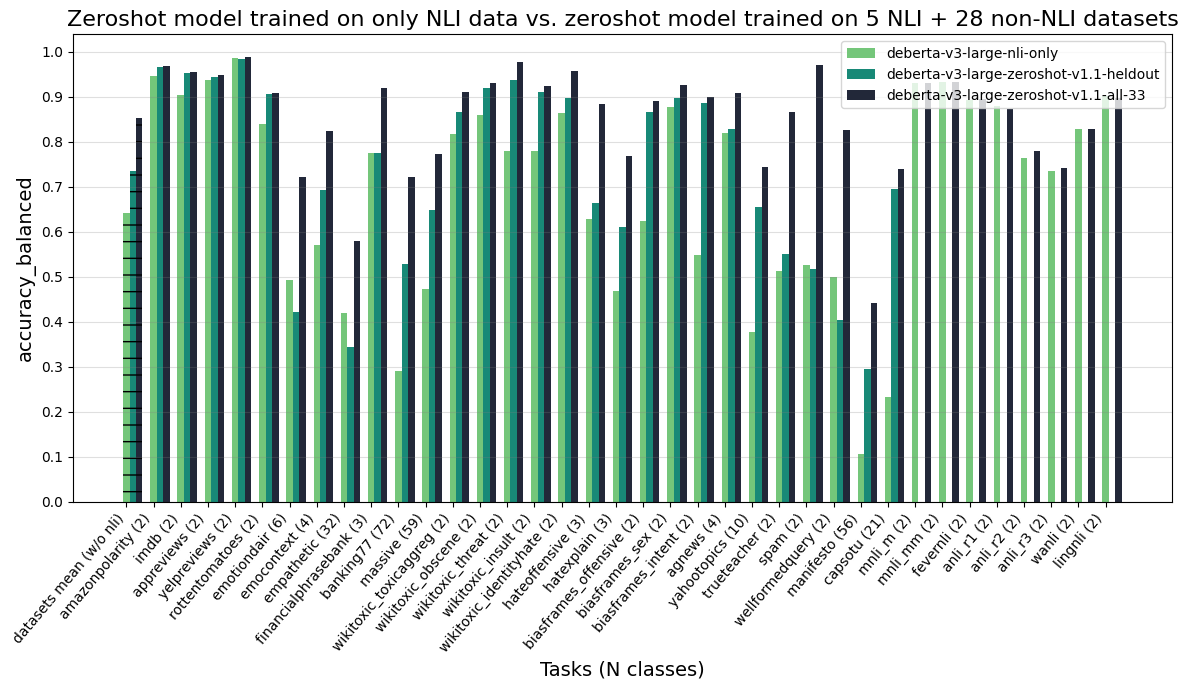

In [7]:
import matplotlib.pyplot as plt

dataset_names = list(run_metrics_viz[list(run_metrics_viz.keys())[0]].keys())

# Set up the plotting parameters
width = 0.25
gap = 0.10  # spacing between groups
group_width = len(run_metrics_viz) * width + (len(run_metrics_viz)) * gap

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))
colors = ["#74C67A", "#188977", "#222839"]  # "#222839"
hatch_pattern = '-'  # Pattern for highlighting the first group

for i, (key_run_name, values) in enumerate(run_metrics_viz.items()):
    # Create an x-axis position for each bar
    x_positions = [j * group_width + i * width for j in range(len(values))]
    # Plot the bars
    # Add hatch pattern to the first group, leave others as is
    for j, (dataset, value) in enumerate(values.items()):
        # Apply the hatch pattern only to the first dataset's first group
        if j == 0:
            ax.bar(x_positions[j], value, width, label="", color=colors[i], hatch=hatch_pattern)
        else:
            ax.bar(x_positions[j], value, width, label=key_run_name if j == 1 else "", color=colors[i])
    #ax.bar(x_positions, list(values.values()), width, label=key_run_name, color=colors[i])

# Adjust x-axis ticks
ax.set_xticks([i * group_width for i in range(len(dataset_names))])
ax.set_xticklabels(dataset_names, rotation=50, ha='right', fontsize=10)
ax.set_xlabel('Tasks (N classes)', fontsize=14)
ax.set_ylabel(metric_to_extract, fontsize=14)
ax.set_title('Zeroshot model trained on only NLI data vs. zeroshot model trained on 5 NLI + 28 non-NLI datasets', fontsize=16)
#ax.set_title('Performance difference for models trained with identical setup (by accident)', fontsize=16)
ax.legend()
ax.yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=.25)
ax.set_yticks([i * 0.1 for i in range(0, int(1/0.1) + 1)])  # adjust the range as needed based on your data

fig.tight_layout()

# Show the plot
plt.show()


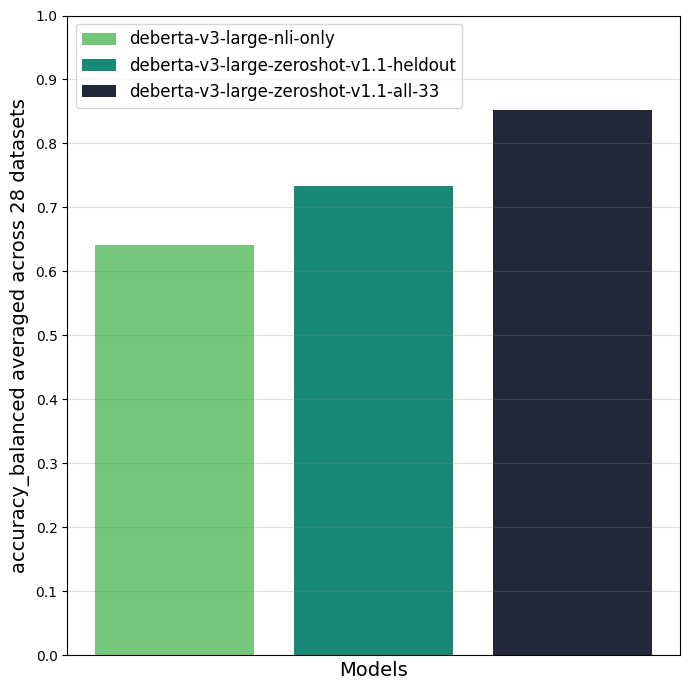

In [46]:
# visualise only average
import matplotlib.pyplot as plt

run_metrics_viz_avg = {key_model: value_model_dic["datasets mean (w/o nli)"] for key_model, value_model_dic in run_metrics_viz.items()}

# Create the figure and axis
fig, ax = plt.subplots(figsize=(7, 7))

colors = ["#74C67A", "#188977", "#222839"]  # "#222839"

bars = plt.bar(run_metrics_viz_avg.keys(), run_metrics_viz_avg.values(), color=colors)

# Adjust x-axis ticks
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel(metric_to_extract + " averaged across 28 datasets", fontsize=14)
#ax.set_title('0-shot classifier trained on only NLI data vs. NLI + 28 non-NLI datasets', fontsize=14)
ax.yaxis.grid(True, linestyle='-', which='major', color='grey', alpha=.25)
ax.set_yticks([i * 0.1 for i in range(0, int(1/0.1) + 1)])  # adjust the range as needed based on your data
plt.xticks([])

#model_names = ["deberta-v3-large-nli-only", "deberta-v3-large-zeroshot-heldout", "3"]
plt.legend(bars, run_metrics_viz_avg.keys(), loc='upper left', fontsize=12)

fig.tight_layout()

# Show the plot
plt.show()


### Tables for paper appendix

In [ ]:
df_metrics = pd.DataFrame(run_metrics_viz).round(3)
display(df_metrics)
#df_metrics.to_markdown()
#df_metrics.to_csv(f"./tables/df_metrics_{MODEL_SIZE}.csv")


,deberta-v3-base-nli-only,deberta-v3-base-zeroshot-v1.1-heldout,deberta-v3-base-zeroshot-v1.1-all-33
datasets mean (w/o nli),0.620,0.707,0.840
amazonpolarity (2),0.917,0.957,0.960
imdb (2),0.873,0.936,0.945
appreviews (2),0.913,0.922,0.944
yelpreviews (2),0.951,0.974,0.983
rottentomatoes (2),0.830,0.887,0.908
emotiondair (6),0.465,0.426,0.745
emocontext (4),0.585,0.574,0.812
empathetic (32),0.313,0.373,0.527
financialphrasebank (3),0.783,0.689,0.912


## Hypotheses tables for model card

In [ ]:
# hypotheses used during training

task_hypotheses = {
    "wellformedquery":
        {
        "well_formed": "This example is a well formed Google query.",
        "not_well_formed": "This example is not a well formed Google query"
        },
    "biasframes_sex":
        {
        "sex": "This example contains allusions to sexual content.",
        "not_sex": "This example does not contain allusions to sexual content."
        },
    "biasframes_intent":
        {
        "intent": "The intent of this example is to be offensive/disrespectful.",
        "not_intent": "The intent of this example is not to be offensive/disrespectful."
        },
    "biasframes_offensive":
        {
        "offensive": "This example could be considered offensive, disrespectful, or toxic.",
        "not_offensive": "This example could not be considered offensive, disrespectful, or toxic."
        },
    "financialphrasebank":
        {
        "negative": "The sentiment in this example is negative from an investor's perspective.",
        "neutral": "The sentiment in this example is neutral from an investor's perspective.",
        "positive": "The sentiment in this example is positive from an investor's perspective."
        },
    "rottentomatoes":
        {
        "negative": "The sentiment in this example rotten tomatoes movie review is negative",
        "positive": "The sentiment in this example rotten tomatoes movie review is positive"
        },
    "amazonpolarity":
        {
        "negative": "The sentiment in this example amazon product review is negative",
        "positive": "The sentiment in this example amazon product review is positive"
        },
    "imdb":
        {
        "negative": "The sentiment in this example imdb movie review is negative",
        "positive": "The sentiment in this example imdb movie review is positive"
        },
    "appreviews":
        {
        "positive": "The sentiment in this example app review is positive.",
        "negative": "The sentiment in this example app review is negative."
        },
    "yelpreviews":
        {
        "positive": "The sentiment in this example yelp review is positive.",
        "negative": "The sentiment in this example yelp review is negative."
        },
    'wikitoxic_toxicaggregated':
        {
        'toxicaggregated': 'This example wikipedia comment contains toxic language.',
        'not_toxicaggregated': 'This example wikipedia comment does not contain toxic language.'
        },
    'wikitoxic_obscene':
        {
        'obscene': 'This example wikipedia comment contains obscene language.',
        'not_obscene': 'This example wikipedia comment does not contain obscene language.'
        },
    'wikitoxic_threat':
        {
        'threat': 'This example wikipedia comment contains a threat.',
        'not_threat': 'This example wikipedia comment does not contain a threat.'
        },
    'wikitoxic_insult':
        {
        'insult': 'This example wikipedia comment contains an insult.',
        'not_insult': 'This example wikipedia comment does not contain an insult.'
        },
    'wikitoxic_identityhate':
        {
        'identityhate': 'This example wikipedia comment contains identity hate.',
        'not_identityhate': 'This example wikipedia comment does not contain identity hate.'
        },
    "hateoffensive":
        {
        "hate_speech": "This example tweet contains hate speech.",
        "offensive": "This example tweet contains offensive language without hate speech.",
        "neither": "This example tweet contains neither offensive language nor hate speech.",
        },
    "hatexplain":
        {
        "hate_speech": "This example text from twitter or gab contains hate speech.",
        "offensive": "This example text from twitter or gab contains offensive language without hate speech.",
        "neither": "This example text from twitter or gab contains neither offensive language nor hate speech.",
        },
    "spam":
         {
         "spam": "This example sms is spam.",
         "not_spam": "This example sms is not spam.",
         },
    "emotiondair":
        {
        'anger': "This example tweet expresses the emotion: anger",
        'fear': "This example tweet expresses the emotion: fear",
        'joy': "This example tweet expresses the emotion: joy",
        'love': "This example tweet expresses the emotion: love",
        'sadness': "This example tweet expresses the emotion: sadness",
        'surprise': "This example tweet expresses the emotion: surprise",
        },
    "emocontext":
        {
        'angry': "This example tweet expresses the emotion: anger",
        'sad': "This example tweet expresses the emotion: sadness",
        'happy': "This example tweet expresses the emotion: happiness",
        'others': "This example tweet does not express any of the emotions: anger, sadness, or happiness",
        },
    "empathetic":
        {
        'afraid': 'The main emotion of this example dialogue is: afraid',
        'angry': 'The main emotion of this example dialogue is: angry',
        'annoyed': 'The main emotion of this example dialogue is: annoyed',
        'anticipating': 'The main emotion of this example dialogue is: anticipating',
        'anxious': 'The main emotion of this example dialogue is: anxious',
        'apprehensive': 'The main emotion of this example dialogue is: apprehensive',
        'ashamed': 'The main emotion of this example dialogue is: ashamed',
        'caring': 'The main emotion of this example dialogue is: caring',
        'confident': 'The main emotion of this example dialogue is: confident',
        'content': 'The main emotion of this example dialogue is: content',
        'devastated': 'The main emotion of this example dialogue is: devastated',
        'disappointed': 'The main emotion of this example dialogue is: disappointed',
        'disgusted': 'The main emotion of this example dialogue is: disgusted',
        'embarrassed': 'The main emotion of this example dialogue is: embarrassed',
        'excited': 'The main emotion of this example dialogue is: excited',
        'faithful': 'The main emotion of this example dialogue is: faithful',
        'furious': 'The main emotion of this example dialogue is: furious',
        'grateful': 'The main emotion of this example dialogue is: grateful',
        'guilty': 'The main emotion of this example dialogue is: guilty',
        'hopeful': 'The main emotion of this example dialogue is: hopeful',
        'impressed': 'The main emotion of this example dialogue is: impressed',
        'jealous': 'The main emotion of this example dialogue is: jealous',
        'joyful': 'The main emotion of this example dialogue is: joyful',
        'lonely': 'The main emotion of this example dialogue is: lonely',
        'nostalgic': 'The main emotion of this example dialogue is: nostalgic',
        'prepared': 'The main emotion of this example dialogue is: prepared',
        'proud': 'The main emotion of this example dialogue is: proud',
        'sad': 'The main emotion of this example dialogue is: sad',
        'sentimental': 'The main emotion of this example dialogue is: sentimental',
        'surprised': 'The main emotion of this example dialogue is: surprised',
        'terrified': 'The main emotion of this example dialogue is: terrified',
        'trusting': 'The main emotion of this example dialogue is: trusting'
        },
    "agnews":
        {
        'Business': "This example news text is about business news",
        'Sci/Tech': "This example news text is about science and technology",
        'Sports': "This example news text is about sports",
        'World': "This example news text is about world news"
        },
    "yahootopics":
        {
        'Business & Finance': 'This example question from the Yahoo Q&A forum is categorized in the topic: Business & Finance',
        'Computers & Internet': 'This example question from the Yahoo Q&A forum is categorized in the topic: Computers & Internet',
        'Education & Reference': 'This example question from the Yahoo Q&A forum is categorized in the topic: Education & Reference',
        'Entertainment & Music': 'This example question from the Yahoo Q&A forum is categorized in the topic: Entertainment & Music',
        'Family & Relationships': 'This example question from the Yahoo Q&A forum is categorized in the topic: Family & Relationships',
        'Health': 'This example question from the Yahoo Q&A forum is categorized in the topic: Health',
        'Politics & Government': 'This example question from the Yahoo Q&A forum is categorized in the topic: Politics & Government',
        'Science & Mathematics': 'This example question from the Yahoo Q&A forum is categorized in the topic: Science & Mathematics',
        'Society & Culture': 'This example question from the Yahoo Q&A forum is categorized in the topic: Society & Culture',
        'Sports': 'This example question from the Yahoo Q&A forum is categorized in the topic: Sports'
        },
    "massive":
        {
        'datetime_query': "The intent of this example utterance is a datetime query.",
        'iot_hue_lightchange': "The intent of this example utterance is changing the light.",
        'transport_ticket': "This example utterance is about transport tickets.",
        'takeaway_query': "This example utterance is about takeaway food.",
        'qa_stock': "This example utterance is about stocks.",
        'general_greet': "This example utterance is a general greet.",
        'recommendation_events': "This example utterance is about event recommendations.",
        'music_dislikeness': "The intent of this example utterance is signalling music dislike.",
        'iot_wemo_off': "The intent of this example utterance is turning an IoT device off.",
        'cooking_recipe': "This example utterance is about cooking recipies.",
        'qa_currency': "This example utteranceis about currencies.",
        'transport_traffic': "This example utterance is about transport or traffic.",
        'general_quirky': np.nan,  # unclear category, better to exclude
        'weather_query': "This example utterance is a query about the wheather.",
        'audio_volume_up': "The intent of this example utterance is turning the audio volume up.",
        'email_addcontact': "The intent of this example utterance is adding an email address to contacts.",
        'takeaway_order': "The intent of this example utterance is to order takeaway food.",
        'email_querycontact': "The intent of this example utterance is to query contact details.",
        'iot_hue_lightup': "The intent of this example utterance is to brighten lights.",
        'recommendation_locations': "The intent of this example utterance is receiving recommendations for good locations.",
        'play_audiobook': "The example utterance is related to playing audiobooks.",
        'lists_createoradd': "The example utterance is related to creating or adding to lists.",
        'news_query': "The example utterance is a query about the news.",
        'alarm_query': "The example utterance is a query about alarms.",
        'iot_wemo_on': "The intent of the example utterance is to turn an IoT device on.",
        'general_joke': "The intent of the example utterance is to hear a joke.",
        'qa_definition': "The example utterance is a query about a definition.",
        'social_query': "The example utterance is a query about a social network.",
        'music_settings': "The intent of the example utterance is to change music settings.",
        'audio_volume_other': "The example utterance is related to audio volume.",
        'calendar_remove': "The intent of the example utterance is to remove something from a calendar.",
        'iot_hue_lightdim': "The intent of the example utterance is to dim the lights.",
        'calendar_query': "The example utterance is a query about a calendar.",
        'email_sendemail': "The intent of the example utterance is to send an email.",
        'iot_cleaning': "The intent of the example utterance is for an IoT device to start cleaning.",
        'audio_volume_down': "The intent of the example utterance is to lower the volume.",
        'play_radio': "The intent of the example utterance is to play something on the radio.",
        'cooking_query': "The example utterance is a query about cooking.",
        'datetime_convert': "The example utterance is related to date time changes or conversion.",
        'qa_maths': "The example utterance is a question about maths.",
        'iot_hue_lightoff': "The example utterance is related to turning the lights off.",
        'iot_hue_lighton': "The example utterance is related to turning the lights on.",
        'transport_query': "The example utterance is a query about transport or travels.",
        'music_likeness': "The example utterance is related to liking music.",
        'email_query': "The example utterance is a query about emails.",
        'play_music': "The intent of this example utterance is for an IoT device to play music.",
        'audio_volume_mute': "The intent of this example utterance is to mute the volume.",
        'social_post': "The example utterance is about social media posts.",
        'alarm_set': "The intent of the example utterance is to set an alarm.",
        'qa_factoid': "The example utterance is a factoid question.",
        'calendar_set': "The intent of this example utterance is to set something in a calendar.",
        'play_game': "The intent of this example utterance is to start playing a game.",
        'alarm_remove': "The intent of this example utterance is to remove an alarm.",
        'lists_remove': "The intent of this example utterance is to remove a list or remove something from a list.",
        'transport_taxi': "The intent of this example utterance is to get a taxi.",
        'recommendation_movies': "This example utterance is about movie recommendations.",
        'iot_coffee': "The intent of this example utterance is for an IoT device to make coffee.",
        'music_query': "The example utterance is a query about music.",
        'play_podcasts': "The example utterance is related to playing podcasts.",
        'lists_query': "The example utterance is a query about a list."
        },
    "banking77":
        {
        'activate_my_card': "This banking customer example message is about activating a card.",
        'age_limit': "This banking customer example message is related to age limits.",
        'apple_pay_or_google_pay': "This banking customer example message is about apple pay or google pay",
        'atm_support': "This banking customer example message requests ATM support.",
        'automatic_top_up': "This banking customer example message is about automatic top up.",
        'balance_not_updated_after_bank_transfer': "This banking customer example message is about a balance not updated after a transfer.",
        'balance_not_updated_after_cheque_or_cash_deposit': "This banking customer example message is about a balance not updated after a cheque or cash deposit.",
        'beneficiary_not_allowed': "This banking customer example message is related to a beneficiary not being allowed or a failed transfer.",
        'cancel_transfer': "This banking customer example message is related to the cancellation of a transfer.",
        'card_about_to_expire': "This banking customer example message is related to the expiration of a card.",
        'card_acceptance': "This banking customer example message is related to the scope of acceptance of a card.",
        'card_arrival': "This banking customer example message is about the arrival of a card.",
        'card_delivery_estimate': "This banking customer example message is about a card delivery estimate or timing.",
        'card_linking': np.nan,  # category does not seem coherent.
        'card_not_working': "This banking customer example message is about a card not working.",
        'card_payment_fee_charged': "This banking customer example message is about a card payment fee.",
        'card_payment_not_recognised': "This banking customer example message is about a payment the customer does not recognise.",
        'card_payment_wrong_exchange_rate': "This banking customer example message is about a wrong exchange rate.",
        'card_swallowed': "This banking customer example message is about a card swallowed by a machine.",
        'cash_withdrawal_charge': "This banking customer example message is about a cash withdrawal charge.",
        'cash_withdrawal_not_recognised': "This banking customer example message is about an unrecognised cash withdrawal.",
        'change_pin': "This banking customer example message is about changing a pin code.",
        'compromised_card': "This banking customer example message is about a compromised card.",
        'contactless_not_working': "This banking customer example message is about contactless not working",
        'country_support': "This banking customer example message is about country-specific support.",
        'declined_card_payment': "This banking customer example message is about a declined card payment.",
        'declined_cash_withdrawal': "This banking customer example message is about a declined cash withdrawal.",
        'declined_transfer': "This banking customer example message is about a declined transfer.",
        'direct_debit_payment_not_recognised': "This banking customer example message is about an unrecognised direct debit payment.",
        'disposable_card_limits': "This banking customer example message is about the limits of disposable cards.",
        'edit_personal_details': "This banking customer example message is about editing personal details.",
        'exchange_charge': "This banking customer example message is about exchange rate charges.",
        'exchange_rate': "This banking customer example message is about exchange rates.",
        'exchange_via_app': np.nan, # noisy category
        'extra_charge_on_statement': "This banking customer example message is about an extra charge.",
        'failed_transfer': "This banking customer example message is about a failed transfer.",
        'fiat_currency_support': "This banking customer example message is about fiat currency support",
        'get_disposable_virtual_card': "This banking customer example message is about getting a disposable virtual card.",
        'get_physical_card': np.nan,  # noisy category
        'getting_spare_card': "This banking customer example message is about getting a spare card.",
        'getting_virtual_card': "This banking customer example message is about getting a virtual card.",
        'lost_or_stolen_card': "This banking customer example message is about a lost or stolen card.",
        'lost_or_stolen_phone': "This banking customer example message is about a lost or stolen phone.",
        'order_physical_card': "This banking customer example message is about ordering a card.",
        'passcode_forgotten': "This banking customer example message is about a forgotten passcode.",
        'pending_card_payment': "This banking customer example message is about a pending card payment.",
        'pending_cash_withdrawal': "This banking customer example message is about a pending cash withdrawal.",
        'pending_top_up': "This banking customer example message is about a pending top up.",
        'pending_transfer': "This banking customer example message is about a pending transfer.",
        'pin_blocked': "This banking customer example message is about a blocked pin.",
        'receiving_money': "This banking customer example message is about receiving money.",
        'Refund_not_showing_up': "This customer example message is about a refund not showing up.",
        'request_refund': "This banking customer example message is about a refund request.",
        'reverted_card_payment?': "This banking customer example message is about reverting a card payment.",
        'supported_cards_and_currencies': np.nan,  # don't understand category.
        'terminate_account': "This banking customer example message is about terminating an account.",
        'top_up_by_bank_transfer_charge': np.nan,  # noisy
        'top_up_by_card_charge': "This banking customer example message is about the charge for topping up by card.",
        'top_up_by_cash_or_cheque': "This banking customer example message is about topping up by cash or cheque.",
        'top_up_failed': "This banking customer example message is about top up issues or failures.",
        'top_up_limits': "This banking customer example message is about top up limitations.",
        'top_up_reverted': "This banking customer example message is about issues with topping up.",
        'topping_up_by_card': "This banking customer example message is about topping up by card.",
        'transaction_charged_twice': "This banking customer example message is about a transaction charged twice.",
        'transfer_fee_charged': "This banking customer example message is about an issue with a transfer fee charge.",
        'transfer_into_account': "This banking customer example message is about transfers into the customer's own account.",
        'transfer_not_received_by_recipient': "This banking customer example message is about a transfer that has not arrived yet.",
        'transfer_timing': "This banking customer example message is about transfer timing.",
        'unable_to_verify_identity': "This banking customer example message is about an issue with identity verification.",
        'verify_my_identity': "This banking customer example message is about identity verification.",
        'verify_source_of_funds': "This banking customer example message is about the source of funds.",
        'verify_top_up': "This banking customer example message is about verification and top ups",
        'virtual_card_not_working': "This banking customer example message is about a virtual card not working",
        'visa_or_mastercard': "This banking customer example message is about types of bank cards.",
        'why_verify_identity': "This banking customer example message questions why identity verification is necessary.",
        'wrong_amount_of_cash_received': "This banking customer example message is about a wrong amount of cash received.",
        'wrong_exchange_rate_for_cash_withdrawal': "This banking customer example message is about a wrong exchange rate for a cash withdrawal."
        },
    "trueteacher":
        {
        "factually_inconsistent": "The example summary is factually inconsistent with the full article.",
        "factually_consistent": "The example summary is factually consistent with the full article.",
        },
    "capsotu":
        {
        'Agriculture': "This example text from a US presidential speech is about agriculture",
        'Culture': "This example text from a US presidential speech is about cultural policy",
        'Civil Rights': "This example text from a US presidential speech is about civil rights or minorities or civil liberties",
        'Defense': "This example text from a US presidential speech is about defense or military",
        'Domestic Commerce': "This example text from a US presidential speech is about banking or finance or commerce",
        'Education': "This example text from a US presidential speech is about education",
        'Energy': "This example text from a US presidential speech is about energy or electricity or fossil fuels",
        'Environment': "This example text from a US presidential speech is about the environment or water or waste or pollution",
        'Foreign Trade': "This example text from a US presidential speech is about foreign trade",
        'Government Operations': "This example text from a US presidential speech is about government operations or administration",
        'Health': "This example text from a US presidential speech is about health",
        'Housing': "This example text from a US presidential speech is about community development or housing issues",
        'Immigration': "This example text from a US presidential speech is about migration",
        'International Affairs': "This example text from a US presidential speech is about international affairs or foreign aid",
        'Labor': "This example text from a US presidential speech is about employment or labour",
        'Law and Crime': "This example text from a US presidential speech is about law, crime or family issues",
        'Macroeconomics': "This example text from a US presidential speech is about macroeconomics",
        #'Other': "This example text from a US presidential speech is about other, miscellaneous",
        'Public Lands': "This example text from a US presidential speech is about public lands or water management",
        'Social Welfare': "This example text from a US presidential speech is about social welfare",
        'Technology': "This example text from a US presidential speech is about space or science or technology or communications",
        'Transportation': "This example text from a US presidential speech is about transportation",
        },
    "manifesto":
        {
        "Welfare State Expansion": "This example text from a political party manifesto is positive towards the welfare state, e.g. health care, pensions or social housing",
        "Technology and Infrastructure: Positive": "This example text from a political party manifesto is about technology and infrastructure, e.g. the importance of modernisation of industry, or supportive of public spending on infrastructure/tech",
        "Education Expansion": "This example text from a political party manifesto is about the need to expand/improve policy on education",
        "Environmental Protection": "This example text from a political party manifesto is in favour of environmental protection, e.g. fighting climate change or 'green' policies or preservation of natural resources or animal rights",
        "Law and Order: Positive": "This example text from a political party manifesto is positive towards law and order and strict law enforcement",
        "Equality: Positive": "This example text from a political party manifesto is positive towards equality or social justice, e.g. protection of underprivileged groups or fair distribution of resources",
        "Agriculture and Farmers: Positive": "This example text from a political party manifesto is positive towards policies for agriculture and farmers",
        "Market Regulation": "This example text from a political party manifesto is supports market regulation for a fair and open market, for example for consumer protection or for increased competition or for social market economy",
        "Incentives: Positive": "This example text from a political party manifesto is favourable towards supply side economic policies supporting businesses, for example for incentives like subsidies or tax breaks",
        "Governmental and Administrative Efficiency": "This example text from a political party manifesto is in favour of efficiency in government/administration, for example by restructuring civil service or improving bureaucracy",
        "Labour Groups: Positive": "This example text from a political party manifesto is positive towards labour groups, for example for good working conditions, fair wages or unions",
        "Decentralization": "This example text from a political party manifesto is for decentralisation or federalism",
        "Anti-Growth Economy: Positive": "This example text from a political party manifesto is in favour of anti-growth politics",
        "Culture: Positive": "This example text from a political party manifesto is in favour of cultural policies or leisure facilities, for example museus, libraries or public sport clubs",
        "Non-economic Demographic Groups": "This example text from a political party manifesto favourably mentions non-economic demographic groups like women, students or specific age groups",
        "Military: Positive": "This example text from a political party manifesto is positive towards the military, for example for military spending or rearmament or military treaty obligations",
        "Political Authority": "This example text from a political party manifesto mentions the speaker's competence to govern or other party's lack of such competence, or favourably mentions a strong/stable government",
        "Internationalism: Positive": "This example text from a political party manifesto is in favour of international cooperation with other countries, for example mentions the need for aid to developing countries, or global governance",
        "Democracy": "This example text from a political party manifesto favourably mentions democracy or democratic procedures or institutions",
        "Multiculturalism: Positive": "This example text from a political party manifesto favourably mentions cultural diversity, for example for freedom of religion or linguistic heritages",
        "Freedom and Human Rights": "This example text from a political party manifesto is in favour of freedom and human rights, for example freedom of speech, assembly or against state coercion or for individualism",
        "Economic Growth: Positive": "This example text from a political party manifesto is supportive of economic growth, for example facilitation of more production or government aid for growth",
        "National Way of Life: Positive": "This example text from a political party manifesto is positive towards the national way of life and history, for example pride of citizenship or appeals to patriotism",
        "Underprivileged Minority Groups": "This example text from a political party manifesto favourably mentions underprivileged minorities, for example handicapped, homosexuals or immigrants",
        "Economic Orthodoxy": "This example text from a political party manifesto is for economic orthodoxy, for example reduction of budget deficits, thrift or a strong currency",
        "Traditional Morality: Positive": "This example text from a political party manifesto is favourable towards traditional or religious values, for example for censorship of immoral behavour, for traditional family values or religious institutions",
        "Free Market Economy": "This example text from a political party manifesto is in favour of a free market economy and capitalism",
        "European Community/Union: Positive": "This example text from a political party manifesto is positive towards the EU or European Community, for example EU expansion and integration",
        "Civic Mindedness: Positive": "This example text from a political party manifesto is positive towards national solidarity, civil society or appeals for public spiritedness or against anti-social attitudes",
        "Welfare State Limitation": "This example text from a political party manifesto is for limiting the welfare state, for example public funding for social services or social security, e.g. private care before state care",
        "National Way of Life: Negative": "This example text from a political party manifesto unfavourably mentions a country's nation and history, for example sceptical towards patriotism or national pride",
        "Foreign Special Relationships: Positive": "This example text from a political party manifesto is positive towards particular countries",
        "Protectionism: Negative": "This example text from a political party manifesto is negative towards protectionism, in favour of free trade",
        "European Community/Union: Negative": "This example text from a political party manifesto negatively mentions the EU or European Community",
        "Nationalisation": "This example text from a political party manifesto is positive towards government ownership of industries or land or for economic nationalisation",
        "Political Corruption": "This example text from a political party manifesto is negative towards political corruption or abuse of political/bureaucratic power",
        "Protectionism: Positive": "This example text from a political party manifesto is in favour of protectionism, for example tariffs, export subsidies",
        "Military: Negative": "This example text from a political party manifesto is negative towards the military, for example for decreasing military spending or disarmament",
        "Economic Planning": "This example text from a political party manifesto is positive towards government economic planning, e.g. policy plans or strategies ",
        "Constitutionalism: Negative": "This example text from a political party manifesto is positive towards constitutionalism",
        "Economic Goals": "This example text from a political party manifesto is a broad/general statement on economic goals without specifics",
        "Middle Class and Professional Groups": "This example text from a political party manifesto favourably references the middle class, e.g. white colar groups or the service sector",
        "Controlled Economy": "This example text from a political party manifesto is supportive of direct government control of the economy, e.g. price control or minimum wages",
        "Traditional Morality: Negative": "This example text from a political party manifesto is negative towards traditional morality, for example against religious moral values, for divorce or abortion, for modern families or separation of church and state",
        "Labour Groups: Negative": "This example text from a political party manifesto is negative towards labour groups and unions",
        "Peace": "This example text from a political party manifesto is positive towards peace and peaceful means of solving crises, for example in favour of negotiations and ending wars",
        "Constitutionalism: Positive": "This example text from a political party manifesto is positive towards constitutionalism and the status quo of the constitution",
        "Internationalism: Negative": "This example text from a political party manifesto is sceptical of internationalism, for example negative towards international cooperation, in favour of national sovereignty and unilaterialism",
        "Corporatism/Mixed Economy": "This example text from a political party manifesto is positive towards cooperation of government, employers, and trade unions simultaneously",
        "Education Limitation": "This example text from a political party manifesto is sceptical towards state expenditure on education, for example in favour of study fees or private schools",
        "Marxist Analysis": "This example text from a political party manifesto is positive towards Marxist-Leninist ideas or uses specific Marxist terminology",
        "Multiculturalism: Negative": "This example text from a political party manifesto is sceptical towards multiculturalism, or for cultural integration or appeals to cultural homogeneity in society",
        "Keynesian Demand Management": "This example text from a political party manifesto is for keynesian demand management and demand side economic policies",
        "Foreign Special Relationships: Negative": "This example text from a political party manifesto is negative towards particular countries",
        "Centralisation": "This example text from a political party manifesto is in favour of political centralisation",
        "Anti-Imperialism": "This example text from a political party manifesto is anti-imperialistic, for example against controlling other countries and for greater self-government of colonies",
        }
}

# re-order all hypotheses to be alphabetical based on label_text
task_hypotheses = {key_task_name: dict(sorted(value_task_hypo_dict.items())) for key_task_name, value_task_hypo_dict in task_hypotheses.items()}


In [ ]:
# convert hypotheses dict to table for table for model card

df_task_dic = {}
for key_task_name, value_hypo_dic in task_hypotheses.items():
    label_hypo_lst = [[key, value] for key, value in value_hypo_dic.items()]
    df_task = pd.DataFrame(data=label_hypo_lst, columns=["label", "hypothesis"])
    df_task_dic.update({key_task_name: df_task})

for key_task_name, value_df in df_task_dic.items():
    print(f"#### {key_task_name}")
    print(value_df.to_markdown(index=False))
    #value_df.to_csv(f"./tables/hypo_{key_task_name}.csv" ,index=False)
    #print(value_df.to_latex(index=False, caption=f"Hypotheses for task spam"))


#### wellformedquery
| label           | hypothesis                                     |
|:----------------|:-----------------------------------------------|
| not_well_formed | This example is not a well formed Google query |
| well_formed     | This example is a well formed Google query.    |
#### biasframes_sex
| label   | hypothesis                                                 |
|:--------|:-----------------------------------------------------------|
| not_sex | This example does not contain allusions to sexual content. |
| sex     | This example contains allusions to sexual content.         |
#### biasframes_intent
| label      | hypothesis                                                       |
|:-----------|:-----------------------------------------------------------------|
| intent     | The intent of this example is to be offensive/disrespectful.     |
| not_intent | The intent of this example is not to be offensive/disrespectful. |
#### biasframes_offensive
| label       